[[3.66662231e-01 6.33337769e-01]
 [3.78164892e-04 9.99621835e-01]
 [6.13798727e-01 3.86201273e-01]
 [3.50231061e-01 6.49768939e-01]
 [4.24085262e-01 5.75914738e-01]]


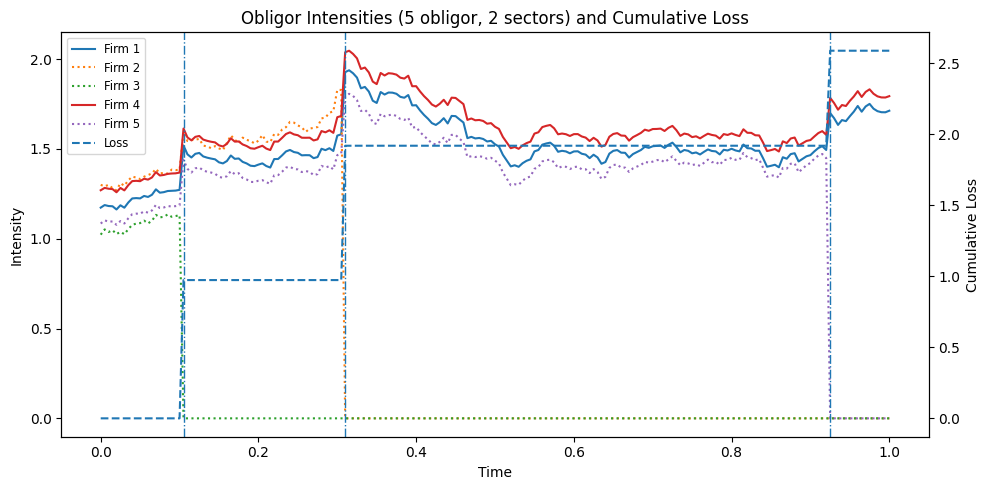

In [ ]:
# Simulation and plotting of intensities for 5 firms and 2 sectors with loss feedback.
# Single-path simulation over time horizon T. Uses exact CIR per-step sampling for sectors,
# discrete-time default sampling (Poisson thinning via Bernoulli per dt), and updates sector factors
# with loss jumps when defaults occur. Produces a plot of firm intensities and cumulative loss.
#
# Notes:
# - Uses exact CIR transition (non-central chi-square) per step for better accuracy.
# - Each firm can default at most once; after default its intensity is set to zero.
# - Loss sizes are drawn from an exponential distribution (mean 1) at default times.
# - No explicit colors/styles are specified (matplotlib defaults used).
#
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

# Model/settings
N = 5         # number of firms
J = 2         # number of sectors
T = 1.0    # total time horizon
dt = 0.005    # time step
steps = int(T/dt)
time_grid = np.linspace(0, T, steps+1)

# CIR parameters per sector
kappa = np.array([1.0, 0.8])
theta = np.array([0.5, 0.3])
sigma = np.array([0.6, 0.5])
Y0 = np.array([0.5, 0.3])

# idiosyncratic constants for each firm (positive)
X = np.array([0.8, 1.0, 0.6, 0.9, 0.7])

# random (but fixed) exposures of each firm to the 2 sectors (rows sum to 1)
raw_w = np.random.rand(N, J)
weights = raw_w / raw_w.sum(axis=1, keepdims=True)
print(weights)

# feedback intensity (impact on sectors per unit loss)
#delta =

# initial sector values
Y = Y0.copy()

# helper: exact CIR transition using non-central chi-square (scalar)
def cir_step_scalar(y_prev, kappa_j, theta_j, sigma_j, dt):
    if y_prev < 0:
        y_prev = 0.0
    exp_k = np.exp(-kappa_j * dt)
    c = (sigma_j**2 * (1 - exp_k)) / (4 * kappa_j)
    nu = 4 * kappa_j * theta_j / (sigma_j**2)
    nonc = (y_prev * exp_k) / c if c>0 else 0.0
    nonc = max(nonc, 0.0)
    # draw non-central chi-square
    sample = np.random.noncentral_chisquare(nu, nonc)
    return c * sample

# storage
Y_path = np.zeros((steps+1, J))
Y_path[0,:] = Y0
lambda_path = np.zeros((steps+1, N))
loss_path = np.zeros(steps+1)

# default bookkeeping
defaulted = np.zeros(N, dtype=bool)
default_times = np.full(N, np.nan)
loss_cumulative = 0.0

# simulate forward
for t in range(steps):
    # compute intensities for alive firms
    lambdas = np.where(defaulted, 0.0, X + (weights @ Y))
    lambda_path[t, :] = lambdas

    # default sampling in this small interval dt (independent conditional on Y)
    # default probability approx 1 - exp(-lambda*dt) ~ lambda*dt for small dt
    probs = 1.0 - np.exp(-lambdas * dt)
    draws = np.random.rand(N) < probs
    # ensure we only accept defaults for firms not defaulted yet
    new_defaults = np.logical_and(draws, ~defaulted)
    if new_defaults.any():
        # for each default, sample loss and update Y via delta*loss
        for idx in np.where(new_defaults)[0]:
            loss_size = np.random.uniform(0,1)#np.random.exponential(scale=1.0)  # exponential loss
            loss_cumulative += loss_size
            # update sector factors with jump (immediate)
            Y = Y + 0.5*weights[idx]*loss_size
            defaulted[idx] = True
            default_times[idx] = time_grid[t+1]
    # record cumulative loss
    loss_path[t+1] = loss_cumulative

    # advance sector factors exactly per-sector
    Y_next = np.zeros_like(Y)
    for j in range(J):
        Y_next[j] = cir_step_scalar(Y[j], kappa[j], theta[j], sigma[j], dt)
    Y = Y_next
    Y_path[t+1,:] = Y

# final intensity snapshot
lambda_path[-1,:] = np.where(defaulted, 0.0, X + (weights @ Y))

# Plotting: intensities for each firm and cumulative loss on secondary axis
fig, ax = plt.subplots(figsize=(10,5))
for i in range(N):
    # label with linestyle differentiating defaulted vs alive (but do not set explicit colors)
    ls = ':' if defaulted[i] else '-'
    ax.plot(time_grid, lambda_path[:, i], linestyle=ls, label=f'Firm {i+1}')

# secondary axis for cumulative loss
ax2 = ax.twinx()
ax2.plot(time_grid, loss_path, linestyle='--', label='Loss', linewidth=1.5)

# vertical lines at default times
for i in range(N):
    if not np.isnan(default_times[i]):
        ax.axvline(default_times[i], linestyle='dashdot', linewidth=1)

ax.set_xlabel('Time')
ax.set_ylabel('Intensity')
ax2.set_ylabel('Cumulative Loss')
ax.set_title('Obligor Intensities (5 obligor, 2 sectors) and Cumulative Loss')
# combined legend: take handles from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()
